# 06. **Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)**

# What we're going to cover

We're going to go through the follow with TensorFlow:
* Downloading and preparing 10% of the Food101 data (10% of training data)
* Training a feature extraction transfer learning model on 10% of the Food101 training data
* Fine-tuning our feature extraction model
* Saving and loaded our trained model
* Evaluating the performance of our Food Vision model trained on 10% of the training data
  * Finding our model's most wrong predictions
* Making predictions with our Food Vision model on custom images of food

# Creating helper functions

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-15 04:11:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-15 04:11:09 (46.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper function of notebook
from helper_functions import walk_through_dir, unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# 101 Food Classes: Working with less data

## Downloading and preprocessing the data

In [ ]:
# Download data from Google Storage (already preformatted)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# unzip_data("101_food_classes_10_percent.zip")

# Create train/ test directory 
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-09-15 04:12:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  77.5MB/s    in 20s     

2021-09-15 04:12:51 (78.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Walk through the data
walk_through_dir("101_food_classes_10_percent/")

There are 2 directories and 0 images in '101_food_classes_10_percent/'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_mousse'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101

Let's use the image_dataset_from_directory() function to turn our images and labels into a tf.data.Dataset, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set shuffle=False so we can perform repeatable evaluation and visualization on it later.

In [ ]:
# Setup data input
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## **Train a big dog model with transfer learning on 10% of 101 food classes**

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",# save the model weights which score the best validation accuracy
                                                         save_best_only=True)

In [ ]:
# Create small data augmentation model with the Sequential API

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)                                
], name = "data_augmentation")

In [ ]:
# Create FUNCTION API MODEL

# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name = "output_layer")(x)

# Combine outputs and inputs in our model
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Inspect the model
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 135s 537ms/step - loss: 3.4550 - accuracy: 0.2465 - val_loss: 2.6632 - val_accuracy: 0.3794
Epoch 2/5
237/237 [==============================] - 103s 433ms/step - loss: 2.3480 - accuracy: 0.4622 - val_loss: 2.1970 - val_accuracy: 0.4553
Epoch 3/5
237/237 [==============================] - 93s 388ms/step - loss: 1.9727 - accuracy: 0.5267 - val_loss: 2.0140 - val_accuracy: 0.4791
Epoch 4/5
237/237 [==============================] - 88s 370ms/step - loss: 1.7614 - accuracy: 0.5707 - val_loss: 1.9335 - val_accuracy: 0.4918
Epoch 5/5
237/237 [==============================] - 89s 376ms/step - loss: 1.5992 - accuracy: 0.6129 - val_loss: 1.8981 - val_accuracy: 0.4959


In [ ]:
# Evaluate the model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 101s 128ms/step - loss: 1.7075 - accuracy: 0.5548


[1.707454800605774, 0.5547722578048706]

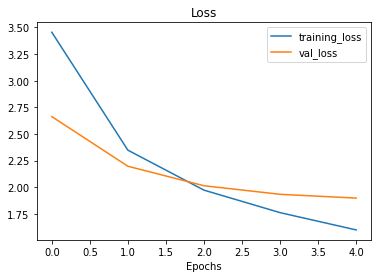

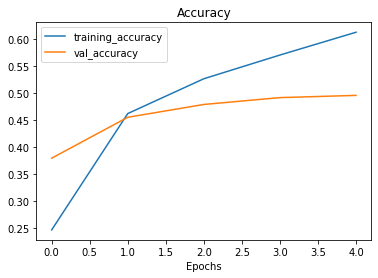

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [ ]:
# Unfreeze all trainable of base model
base_model.trainable = True

# Refreeze all layers except last 5
for layer in base_model.layers[:-5]:
  layer.trainable =  False


In [ ]:
# Recompiling the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [ ]:
# What layer in the model are trainable
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Fine-tune for 5 epochs
fine_tune_epochs= 10 

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 63s 264ms/step - loss: 0.9598 - accuracy: 0.7410 - val_loss: 1.8409 - val_accuracy: 0.5299
Epoch 6/10
237/237 [==============================] - 62s 260ms/step - loss: 0.9035 - accuracy: 0.7572 - val_loss: 1.8537 - val_accuracy: 0.5262
Epoch 7/10
237/237 [==============================] - 63s 266ms/step - loss: 0.8518 - accuracy: 0.7690 - val_loss: 1.8329 - val_accuracy: 0.5339
Epoch 8/10
237/237 [==============================] - 61s 256ms/step - loss: 0.8118 - accuracy: 0.7828 - val_loss: 1.7818 - val_accuracy: 0.5440
Epoch 9/10
237/237 [==============================] - 59s 249ms/step - loss: 0.7873 - accuracy: 0.7853 - val_loss: 1.8814 - val_accuracy: 0.5252
Epoch 10/10
237/237 [==============================] - 60s 252ms/step - loss: 0.7413 - accuracy: 0.8007 - val_loss: 1.8488 - val_accuracy: 0.5381


In [ ]:
# Evaluate fine-tuned model on the whole data set

results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 101s 128ms/step - loss: 1.6182 - accuracy: 0.5811


[1.618233561515808, 0.5811485052108765]

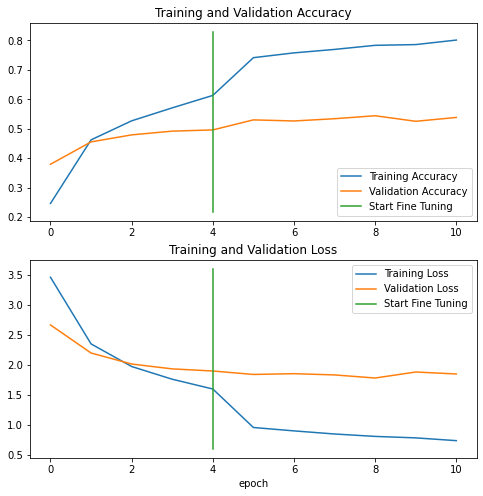

In [ ]:
# Compare 2 history
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving our trained model

In [ ]:
# Save model to drive so it can be used later
model.save()

## Evaluaing the performance of the big dog model across all different class

In [ ]:
import tensorflow as tf

# zip_ref = "/content/drive/MyDrive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model-20210914T084616Z-001.zip"
# unzip_data(zip_ref)

model = tf.keras.models.load_model("/content/101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Check to see if loaded model is trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 107s 133ms/step - loss: 1.6141 - accuracy: 0.5772


(1.6141395568847656, 0.5771881341934204)

## Making predictions with our trained model

In [ ]:
# Maker predictions on test data
pred_probs = model.predict(test_data, verbose = 1) # Set verbosity to see how long its take

790/790 [==============================] - 116s 111ms/step


In [ ]:
# How many predictions are there
len(pred_probs)

25250

In [ ]:
# What's the shape of predictions
pred_probs.shape

(25250, 101)

What we've got is often referred to as a predictions probability tensor (or array).

Let's see what the first 10 look like.

In [ ]:
# How do they look
pred_probs[:10]

array([[4.0622279e-01, 2.6640805e-04, 4.6320003e-02, ..., 3.6114976e-05,
        6.7843014e-04, 3.5994757e-02],
       [8.7468100e-01, 1.2761015e-07, 1.9346466e-03, ..., 7.1280496e-04,
        7.6929132e-07, 4.3818750e-06],
       [2.0631391e-01, 4.3268618e-03, 5.7037771e-03, ..., 1.7708456e-04,
        6.4031052e-04, 4.6294765e-03],
       ...,
       [4.6826532e-01, 3.5759467e-06, 2.1007140e-03, ..., 1.8745944e-02,
        5.0184689e-04, 1.5107977e-04],
       [2.3342341e-01, 5.1096641e-04, 1.0454664e-01, ..., 4.9635727e-04,
        7.5917524e-05, 6.9998531e-04],
       [6.5188324e-01, 2.1300739e-06, 7.4245362e-04, ..., 5.2834982e-03,
        9.7077927e-06, 3.1692523e-03]], dtype=float32)

In [ ]:
class_names = train_data_all_10_percent.class_names

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities of sample 0: {len(pred_probs[0])}")
print(f"Whats prediction probabilities of sample 0 look like: {pred_probs[0]}")
print(f"The class with highest probabilities for sample 0: {pred_probs[0].argmax()}")
print(f"The name of the highest probabilities class: {class_names[pred_probs[0].argmax()]}")

Number of prediction probabilities of sample 0: 101
Whats prediction probabilities of sample 0 look like: [4.0622279e-01 2.6640805e-04 4.6320003e-02 3.2004895e-08 2.8563420e-06
 7.7256357e-07 1.2358889e-04 3.3489243e-05 5.7700187e-02 5.8812427e-04
 1.7719068e-06 2.9385215e-05 1.7253258e-03 1.3381152e-06 9.5359515e-03
 8.0808194e-04 2.5106070e-05 7.3110021e-04 8.5565541e-04 2.7296483e-06
 7.6184857e-05 2.8600700e-05 1.7103447e-04 1.2553108e-04 5.0157536e-04
 2.1509214e-04 2.4425396e-04 2.9168608e-05 2.2310629e-01 9.9290709e-04
 2.6361356e-06 3.8671974e-04 4.0038564e-04 2.4459553e-07 2.8876637e-03
 2.2322434e-05 8.1449623e-05 6.1663886e-04 1.3205707e-02 1.6941072e-05
 2.7644596e-04 1.8197908e-03 3.1834855e-04 3.5120311e-06 1.8986026e-05
 4.8861271e-05 7.5978693e-04 1.0407532e-03 1.8491947e-06 6.7667827e-02
 1.8972513e-04 1.1668417e-05 2.5551859e-02 5.7345410e-03 1.5826967e-05
 2.3299370e-02 1.5480630e-02 3.8838957e-04 2.1190220e-03 1.9949908e-05
 2.9506722e-07 1.6293568e-04 1.2935944e-02

In [ ]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  9,  0])

In [ ]:
test_data.unbatch()

<_UnbatchDataset shapes: ((224, 224, 3), (101,)), types: (tf.float32, tf.float32)>

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]  

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's `accuracy_score()`

In [ ]:
# Get accuraccy score by comparing predict classes to ground truth classes
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(pred_classes, y_labels)
sklearn_accuracy

0.5771881188118811

In [ ]:
# Does the evaluate method compare to the skleran measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy-sklearn_accuracy}")

Close? True | Difference: 1.538153926450292e-08


In [ ]:
from helper_functions import confusion_matrix

In [ ]:
## Note: The following confusion matrix code is a remix of Scikit-Learn's 

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15, norm=False, savefig=False):

  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """

  # Create the confusion matrix
  cm =  confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # Normalize it
  n_classes = cm.shape[0]

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         yticks=np.arange(n_classes),
         xticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names
         yticklabels= labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readibility & increase font size
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshhold for different colors
  threshold = (cm.max() + cm.min())  / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i,j] > threshold else "black",
               size=text_size)
    else:
      plt.text(j, i, f"{cm[i,j]}",
               horizontalalignment="center",
               color="white" if cm[i,j] > threshold else "black",
               size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")          


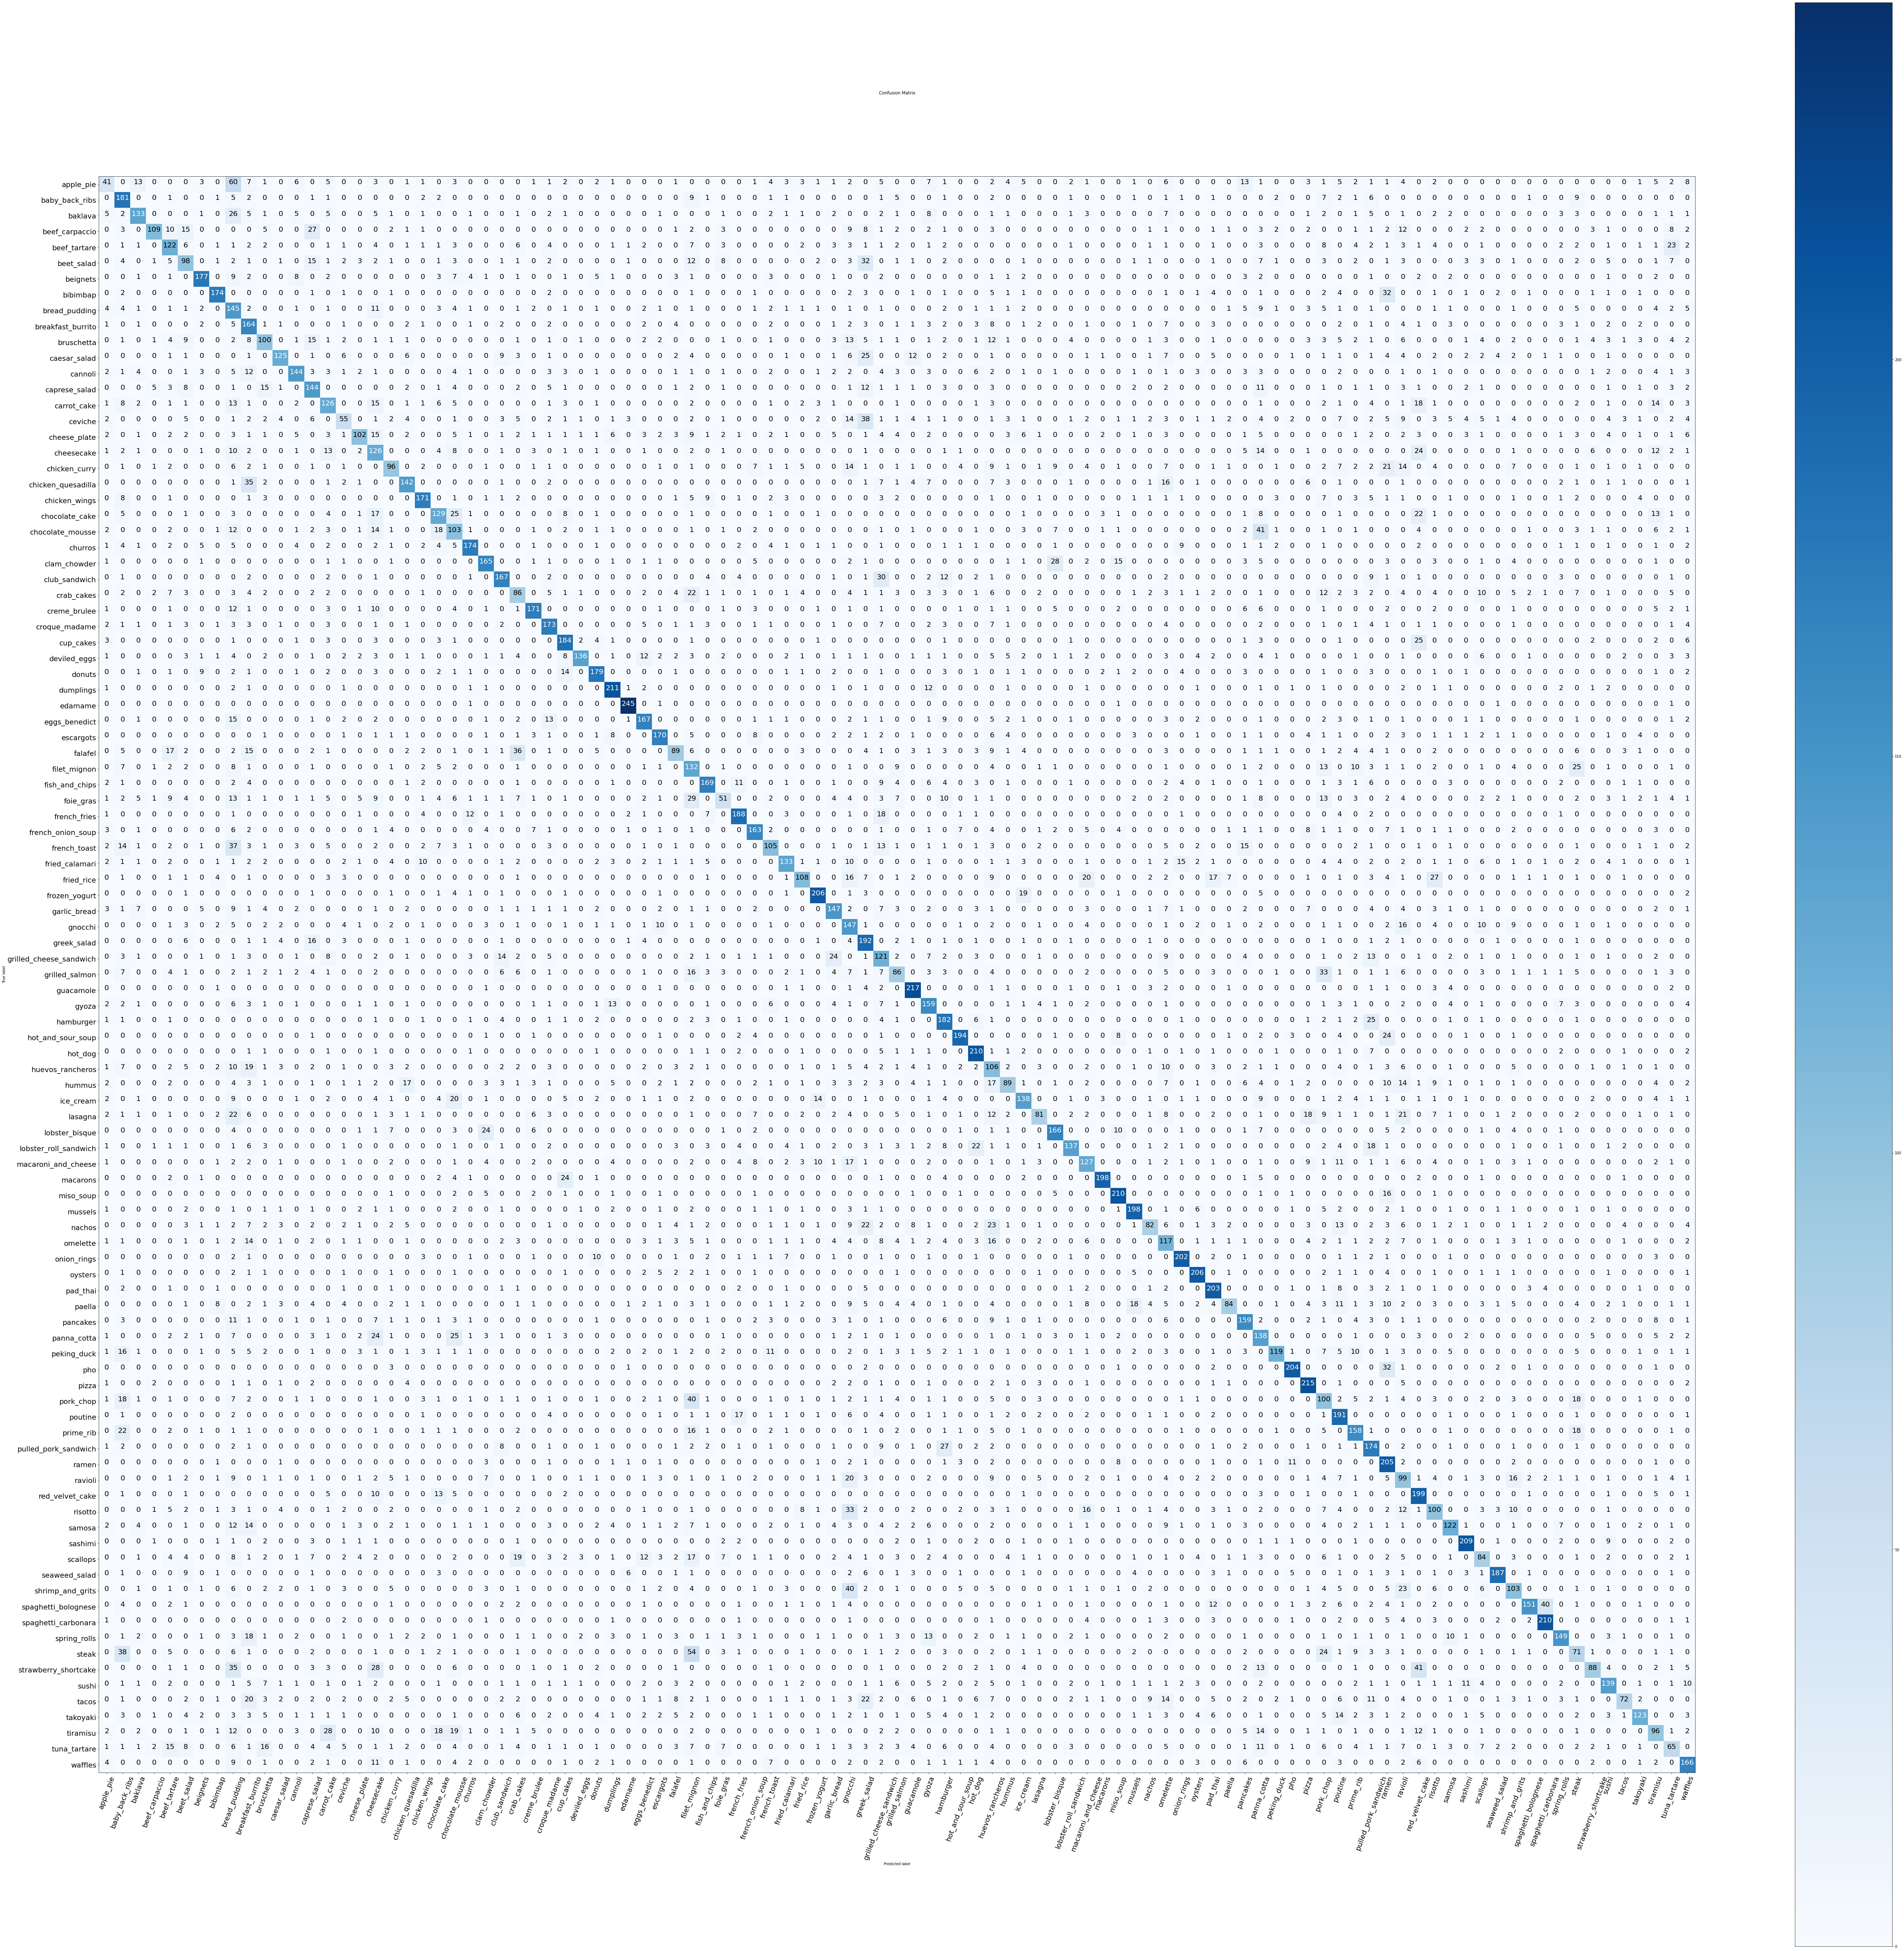

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's classification_report() function.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.16      0.23       250
           1       0.45      0.72      0.56       250
           2       0.68      0.53      0.60       250
           3       0.84      0.44      0.58       250
           4       0.47      0.49      0.48       250
           5       0.43      0.39      0.41       250
           6       0.80      0.71      0.75       250
           7       0.82      0.70      0.75       250
           8       0.22      0.58      0.32       250
           9       0.38      0.66      0.48       250
          10       0.49      0.40      0.44       250
          11       0.76      0.50      0.60       250
          12       0.72      0.58      0.64       250
          13       0.49      0.58      0.53       250
          14       0.48      0.50      0.49       250
          15       0.44      0.22      0.29       250
          16       0.70      0.41      0.52       250
          17       0.34    

First, we'll get the output of classification_report() as a dictionary by setting output_dict=True.

In [ ]:
# Get a dictionary of the classifiaction report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict= True)
classification_report_dict

{'0': {'f1-score': 0.22527472527472525,
  'precision': 0.35964912280701755,
  'recall': 0.164,
  'support': 250},
 '1': {'f1-score': 0.5560675883256528,
  'precision': 0.4513715710723192,
  'recall': 0.724,
  'support': 250},
 '10': {'f1-score': 0.4385964912280702,
  'precision': 0.4854368932038835,
  'recall': 0.4,
  'support': 250},
 '100': {'f1-score': 0.6240601503759399,
  'precision': 0.5886524822695035,
  'recall': 0.664,
  'support': 250},
 '11': {'f1-score': 0.6038647342995169,
  'precision': 0.7621951219512195,
  'recall': 0.5,
  'support': 250},
 '12': {'f1-score': 0.6385809312638581,
  'precision': 0.7164179104477612,
  'recall': 0.576,
  'support': 250},
 '13': {'f1-score': 0.5313653136531366,
  'precision': 0.4931506849315068,
  'recall': 0.576,
  'support': 250},
 '14': {'f1-score': 0.4941176470588235,
  'precision': 0.4846153846153846,
  'recall': 0.504,
  'support': 250},
 '15': {'f1-score': 0.29333333333333333,
  'precision': 0.44,
  'recall': 0.22,
  'support': 250},


To extract it, we'll create an empty dictionary called class_f1_scores and then loop through each item in classification_report_dict, appending the class name and f1-score as the key, value pairs in class_f1_scores

In [ ]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # Stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores


{'apple_pie': 0.22527472527472525,
 'baby_back_ribs': 0.5560675883256528,
 'baklava': 0.597752808988764,
 'beef_carpaccio': 0.575197889182058,
 'beef_tartare': 0.48126232741617353,
 'beet_salad': 0.4100418410041841,
 'beignets': 0.751592356687898,
 'bibimbap': 0.7548806941431668,
 'bread_pudding': 0.31833150384193193,
 'breakfast_burrito': 0.47743813682678315,
 'bruschetta': 0.4385964912280702,
 'caesar_salad': 0.6038647342995169,
 'cannoli': 0.6385809312638581,
 'caprese_salad': 0.5313653136531366,
 'carrot_cake': 0.4941176470588235,
 'ceviche': 0.29333333333333333,
 'cheese_plate': 0.5164556962025316,
 'cheesecake': 0.40514469453376206,
 'chicken_curry': 0.45933014354066987,
 'chicken_quesadilla': 0.6055437100213219,
 'chicken_wings': 0.7184873949579833,
 'chocolate_cake': 0.5254582484725051,
 'chocolate_mousse': 0.3672014260249555,
 'churros': 0.742004264392324,
 'clam_chowder': 0.673469387755102,
 'club_sandwich': 0.6720321931589537,
 'crab_cakes': 0.3590814196242171,
 'creme_brule

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

f1_scores.head(20)                       

,class_names,f1-score
33,edamame,0.951456
63,macarons,0.857143
75,pho,0.837782
86,sashimi,0.831014
91,spaghetti_carbonara,0.818713
45,frozen_yogurt,0.817460
69,oysters,0.814229
54,hot_and_sour_soup,0.810021
68,onion_rings,0.808000
64,miso_soup,0.804598


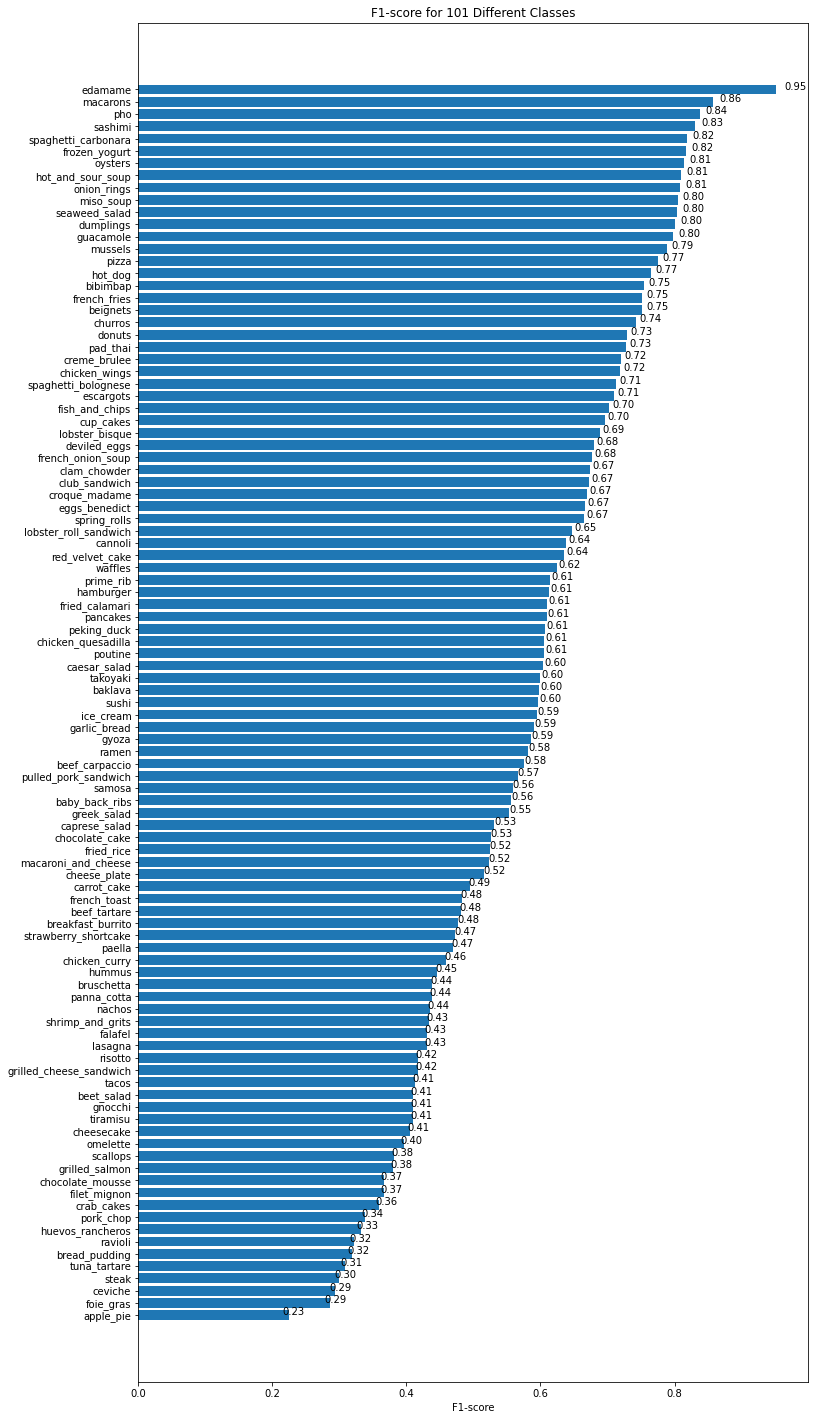

In [ ]:
# Create a horizontal bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 Different Classes")
ax.invert_yaxis();

def auto_label(rects):
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height() /1.5,
            f"{width:.2f}",
            ha="center", va="bottom")
    
auto_label(scores)    

## Visualizing predictions on test images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale = True):
  # Read in the target image
  img = tf.io.read_file(filename)
  # Turn image into tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Sacle the image
  if scale:
    return img/255.
  else:
    return img

In [ ]:
os.listdir(test_dir)[:5], class_names[:5]

(['poutine', 'french_fries', 'fried_calamari', 'chocolate_mousse', 'bibimbap'],
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare'])

In [ ]:
random.choice(os.listdir(test_dir + "/" + class_name))

'3417748.jpg'

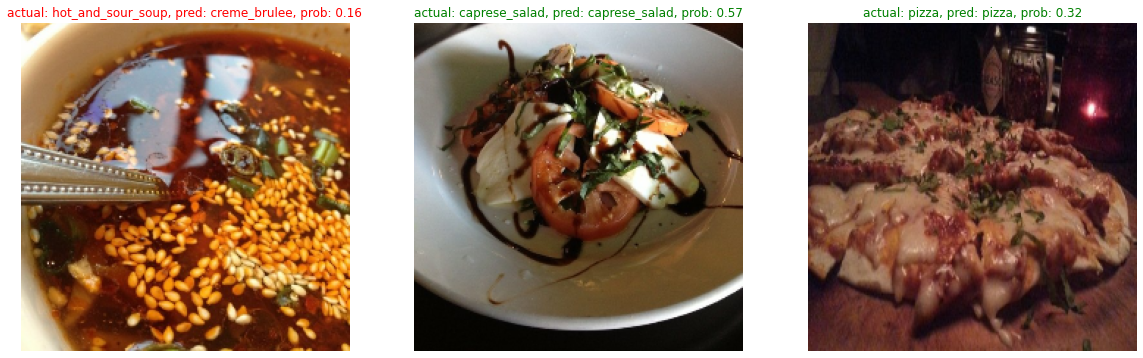

In [ ]:
# Make preds on serires of random images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
  # Choose a random image from a rando class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make prediction
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()]

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color= "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding most wrong predictions